<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tl;dr" data-toc-modified-id="tl;dr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tl;dr</a></span></li><li><span><a href="#setup" data-toc-modified-id="setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#neural-network-architecture" data-toc-modified-id="neural-network-architecture-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>neural network architecture</a></span></li><li><span><a href="#data" data-toc-modified-id="data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#training" data-toc-modified-id="training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>training</a></span></li><li><span><a href="#results" data-toc-modified-id="results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>results</a></span></li></ul></div>

# tl;dr

in this notebook we will try to make some experiments with the **damped harmonic oscillator** (dho) synthetic data. here the goal is to vary some hyperparameters and see how the model behaves in terms interpolation -- rather than extrapolation.

# setup

In [85]:
import os
# import pprint
# import functools
import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import torch
import torch.nn as nn
import torch.optim as optim

# import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

%matplotlib inline

In [86]:
mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['text.usetex'] = True

experiment_name = "dho_curve_learning"

folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

golden_ratio = (np.sqrt(5) - 1) / 2

# neural network architecture

In [87]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

$$ \ddot{x} + \frac{\mu}{m} \dot{x} + \frac{k}{m} x = 0 $$

# data

,time,displacement
0,0.618593,0.273303
1,0.558739,0.007569
2,0.193708,-0.558020
3,0.335972,0.489996
4,0.200845,-0.489805


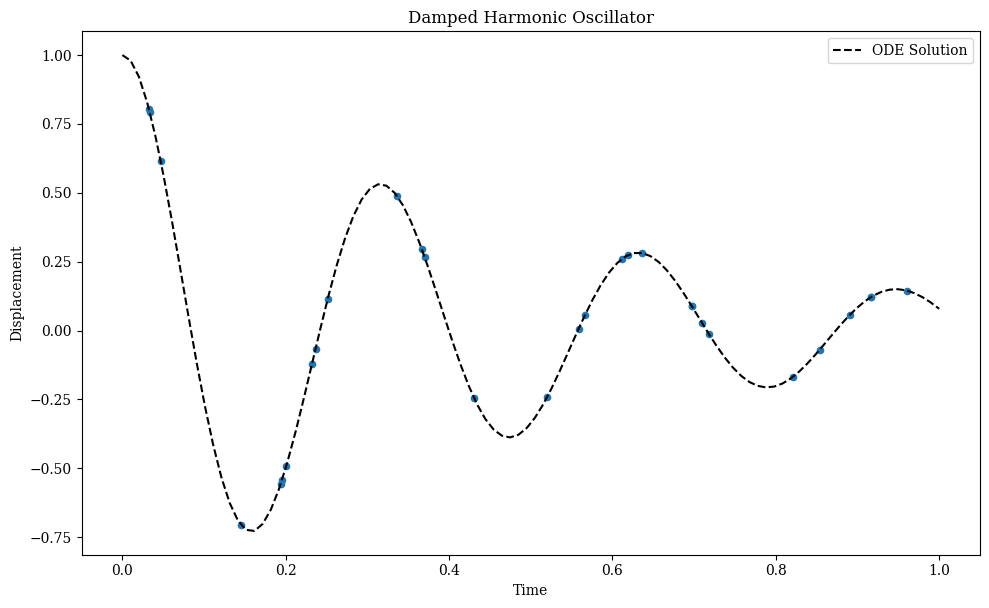

In [88]:
def oscillator(d, w0, x):
    """
    oscillator
    """
    w = np.sqrt(w0 ** 2 - d ** 2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = torch.cos(phi + w * x)
    sin = torch.sin(phi + w * x)
    exp = torch.exp(-d * x)
    y = exp * 2 * A * cos
    return y

torch.manual_seed(33) 

d, w0 = 2, 20
x = torch.rand(30)
y = oscillator(d, w0, x).view(-1,1)

X = pd.DataFrame({"time": x.view(-1), "displacement": y.view(-1)})

display(X.head())
X.to_parquet(f"{folder_path}/synthetic_data.parquet")

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))

X.plot.scatter(x="time", y="displacement", ax=ax1,)

t = np.linspace(0, 1, 100)
ax1.plot(t, oscillator(d, w0, torch.tensor(t)).detach().numpy(), label="ODE Solution", c="k", linestyle="--",)

ax1.set_xlabel("Time")
ax1.set_ylabel("Displacement")
ax1.set_title("Damped Harmonic Oscillator")
ax1.legend()

plt.tight_layout()
plt.savefig(f"{folder_path}/displacement_vs_time.png", dpi=300)

# interpolation

## training

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|          | 0/50000 [00:00<?, ?it/s]

  2%|▏         | 1038/50000 [00:03<03:05, 263.46it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.128970, Physics Loss: 0.103512, x0 Loss: 0.994663, v0 Loss: 0.000447, Total Loss: 0.130069


  4%|▍         | 2024/50000 [00:07<02:58, 269.28it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.128903, Physics Loss: 0.145536, x0 Loss: 0.993778, v0 Loss: 0.000744, Total Loss: 0.130043


  6%|▌         | 3047/50000 [00:10<02:25, 323.04it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.128814, Physics Loss: 0.243084, x0 Loss: 0.992496, v0 Loss: 0.001029, Total Loss: 0.130050


  8%|▊         | 4045/50000 [00:14<02:47, 274.55it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.128822, Physics Loss: 0.209351, x0 Loss: 0.992709, v0 Loss: 0.001225, Total Loss: 0.130025


 10%|█         | 5034/50000 [00:18<03:50, 195.12it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.128810, Physics Loss: 0.216277, x0 Loss: 0.992568, v0 Loss: 0.001316, Total Loss: 0.130020


 12%|█▏        | 6047/50000 [00:22<02:42, 270.73it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.128793, Physics Loss: 0.224165, x0 Loss: 0.992377, v0 Loss: 0.001465, Total Loss: 0.130011


 14%|█▍        | 7028/50000 [00:27<03:42, 193.01it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.128776, Physics Loss: 0.229605, x0 Loss: 0.992188, v0 Loss: 0.001641, Total Loss: 0.129999


 16%|█▌        | 8037/50000 [00:30<02:39, 263.07it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.128746, Physics Loss: 0.236853, x0 Loss: 0.991823, v0 Loss: 0.002062, Total Loss: 0.129976


 18%|█▊        | 9032/50000 [00:35<03:15, 210.04it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.128952, Physics Loss: 1.357347, x0 Loss: 0.994670, v0 Loss: 0.003524, Total Loss: 0.131308


 20%|██        | 10025/50000 [00:39<03:13, 206.60it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.128508, Physics Loss: 0.343331, x0 Loss: 0.989632, v0 Loss: 0.005016, Total Loss: 0.129846


 22%|██▏       | 11037/50000 [00:43<03:09, 205.23it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.128436, Physics Loss: 0.386151, x0 Loss: 0.988798, v0 Loss: 0.006408, Total Loss: 0.129817


 24%|██▍       | 12028/50000 [00:46<02:30, 251.66it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.128398, Physics Loss: 0.594617, x0 Loss: 0.986051, v0 Loss: 0.007953, Total Loss: 0.129986


 26%|██▌       | 13063/50000 [00:50<01:55, 320.56it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.128231, Physics Loss: 0.482729, x0 Loss: 0.986838, v0 Loss: 0.010132, Total Loss: 0.129711


 28%|██▊       | 14040/50000 [00:54<02:25, 246.32it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.127780, Physics Loss: 0.647406, x0 Loss: 0.983270, v0 Loss: 0.018001, Total Loss: 0.129429


 30%|███       | 15033/50000 [00:57<01:54, 306.51it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.124209, Physics Loss: 1.955544, x0 Loss: 0.963130, v0 Loss: 0.027688, Total Loss: 0.127155


 32%|███▏      | 16053/50000 [01:01<01:57, 288.59it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.110608, Physics Loss: 4.823097, x0 Loss: 0.867388, v0 Loss: 0.049964, Total Loss: 0.116349


 34%|███▍      | 17050/50000 [01:05<02:02, 269.40it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.092768, Physics Loss: 6.985498, x0 Loss: 0.744588, v0 Loss: 0.944732, Total Loss: 0.101443


 36%|███▌      | 18050/50000 [01:09<01:58, 269.86it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.060401, Physics Loss: 19.408535, x0 Loss: 0.485456, v0 Loss: 1.831769, Total Loss: 0.082127


 38%|███▊      | 19038/50000 [01:13<02:01, 255.82it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.042951, Physics Loss: 16.949627, x0 Loss: 0.343051, v0 Loss: 1.504977, Total Loss: 0.061748


 40%|████      | 20036/50000 [01:17<02:05, 238.32it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.033762, Physics Loss: 19.732973, x0 Loss: 0.267041, v0 Loss: 1.340211, Total Loss: 0.055102


 42%|████▏     | 21028/50000 [01:20<02:26, 197.89it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.029230, Physics Loss: 19.901289, x0 Loss: 0.229906, v0 Loss: 1.241291, Total Loss: 0.050603


 44%|████▍     | 22059/50000 [01:25<01:21, 343.47it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.025527, Physics Loss: 18.896793, x0 Loss: 0.200194, v0 Loss: 1.112712, Total Loss: 0.045736


 46%|████▌     | 23031/50000 [01:29<02:13, 201.47it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.021039, Physics Loss: 16.801344, x0 Loss: 0.164727, v0 Loss: 0.927151, Total Loss: 0.038932


 48%|████▊     | 24038/50000 [01:33<01:53, 229.37it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.017685, Physics Loss: 15.453691, x0 Loss: 0.138609, v0 Loss: 0.826349, Total Loss: 0.034104


 50%|█████     | 25035/50000 [01:38<02:03, 201.48it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.014585, Physics Loss: 13.974224, x0 Loss: 0.114117, v0 Loss: 0.747659, Total Loss: 0.029421


 52%|█████▏    | 26030/50000 [01:43<01:59, 200.55it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.012324, Physics Loss: 13.306540, x0 Loss: 0.096144, v0 Loss: 0.670202, Total Loss: 0.026397


 54%|█████▍    | 27032/50000 [01:47<01:47, 212.79it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.010261, Physics Loss: 12.810946, x0 Loss: 0.079984, v0 Loss: 0.620288, Total Loss: 0.023772


 56%|█████▌    | 28029/50000 [01:52<01:44, 209.82it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.008753, Physics Loss: 12.336802, x0 Loss: 0.068689, v0 Loss: 0.550559, Total Loss: 0.021709


 58%|█████▊    | 29039/50000 [01:57<01:45, 198.91it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.007392, Physics Loss: 11.163815, x0 Loss: 0.057938, v0 Loss: 0.504076, Total Loss: 0.019118


 60%|██████    | 30050/50000 [02:01<01:14, 268.98it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.005982, Physics Loss: 10.274520, x0 Loss: 0.047520, v0 Loss: 0.459362, Total Loss: 0.016763


 62%|██████▏   | 31053/50000 [02:04<01:00, 315.76it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.005001, Physics Loss: 12.472890, x0 Loss: 0.039818, v0 Loss: 0.418832, Total Loss: 0.017932


 64%|██████▍   | 32031/50000 [02:08<01:04, 277.40it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.003909, Physics Loss: 11.050646, x0 Loss: 0.032755, v0 Loss: 0.461005, Total Loss: 0.015454


 66%|██████▌   | 33063/50000 [02:11<00:49, 342.84it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.003097, Physics Loss: 8.023687, x0 Loss: 0.025738, v0 Loss: 0.322104, Total Loss: 0.011468


 68%|██████▊   | 34045/50000 [02:15<00:58, 273.07it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002642, Physics Loss: 16.128065, x0 Loss: 0.019706, v0 Loss: 0.311745, Total Loss: 0.019101


 70%|███████   | 35039/50000 [02:19<01:13, 202.40it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.001915, Physics Loss: 6.630530, x0 Loss: 0.016455, v0 Loss: 0.231914, Total Loss: 0.008794


 72%|███████▏  | 36034/50000 [02:23<01:09, 199.61it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.001558, Physics Loss: 6.579779, x0 Loss: 0.012981, v0 Loss: 0.199814, Total Loss: 0.008351


 74%|███████▍  | 37049/50000 [02:26<00:38, 335.99it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.001264, Physics Loss: 5.401533, x0 Loss: 0.011137, v0 Loss: 0.161887, Total Loss: 0.006839


 76%|███████▌  | 38052/50000 [02:29<00:32, 367.14it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.001078, Physics Loss: 4.932346, x0 Loss: 0.009441, v0 Loss: 0.136009, Total Loss: 0.006156


 78%|███████▊  | 39068/50000 [02:32<00:30, 356.86it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000905, Physics Loss: 8.599751, x0 Loss: 0.006839, v0 Loss: 0.115576, Total Loss: 0.009628


 80%|████████  | 40058/50000 [02:34<00:27, 357.54it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000884, Physics Loss: 9.653148, x0 Loss: 0.008141, v0 Loss: 0.098914, Total Loss: 0.010644


 82%|████████▏ | 41036/50000 [02:37<00:25, 350.79it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000674, Physics Loss: 3.687701, x0 Loss: 0.006207, v0 Loss: 0.086179, Total Loss: 0.004454


 84%|████████▍ | 42056/50000 [02:40<00:22, 356.63it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000592, Physics Loss: 3.410207, x0 Loss: 0.005508, v0 Loss: 0.074937, Total Loss: 0.004082


 86%|████████▌ | 43064/50000 [02:43<00:21, 322.30it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000599, Physics Loss: 7.173241, x0 Loss: 0.005448, v0 Loss: 0.075471, Total Loss: 0.007853


 88%|████████▊ | 44042/50000 [02:46<00:17, 341.33it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000492, Physics Loss: 3.790922, x0 Loss: 0.004423, v0 Loss: 0.058045, Total Loss: 0.004345


 90%|█████████ | 45048/50000 [02:49<00:14, 335.05it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000442, Physics Loss: 2.945848, x0 Loss: 0.004252, v0 Loss: 0.053184, Total Loss: 0.003445


 92%|█████████▏| 46028/50000 [02:53<00:19, 207.72it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000397, Physics Loss: 2.719921, x0 Loss: 0.003807, v0 Loss: 0.049483, Total Loss: 0.003170


 94%|█████████▍| 47056/50000 [02:59<00:11, 248.71it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000382, Physics Loss: 2.689106, x0 Loss: 0.003638, v0 Loss: 0.042177, Total Loss: 0.003117


 96%|█████████▌| 48020/50000 [03:03<00:10, 197.24it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000468, Physics Loss: 27.554327, x0 Loss: 0.001907, v0 Loss: 0.043948, Total Loss: 0.028068


 98%|█████████▊| 49021/50000 [03:08<00:03, 250.99it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000342, Physics Loss: 2.489402, x0 Loss: 0.003311, v0 Loss: 0.039350, Total Loss: 0.002874


100%|██████████| 50000/50000 [03:12<00:00, 260.26it/s]


mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.000364, Physics Loss: 4.575650, x0 Loss: 0.003173, v0 Loss: 0.033885, Total Loss: 0.004977


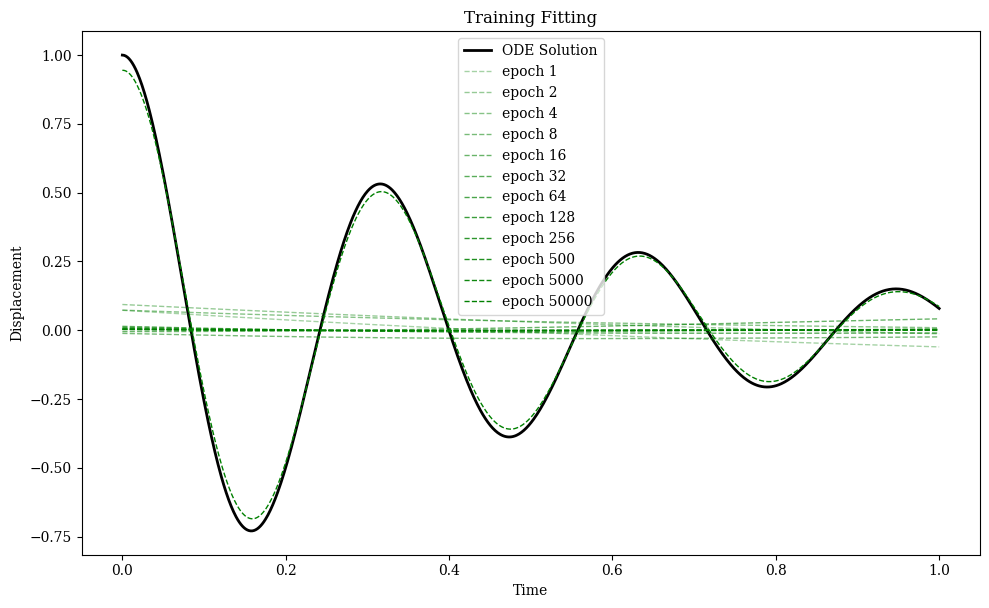

In [108]:
m = 1
# k = 1
# mu = 0.1
mu, k = 2*d, w0**2
x_0 = 1
v_0 = 0

torch.manual_seed(123)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_test_threshold = 1

x_train = torch.tensor(X.query(f"time <= {train_test_threshold}")["time"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X.query(f"time <= {train_test_threshold}")["displacement"].values).float().unsqueeze(1).to(device)

x_test = torch.tensor(X.query(f"time > {train_test_threshold}")["time"].values).float().unsqueeze(1).to(device)
y_test = torch.tensor(X.query(f"time > {train_test_threshold}")["displacement"].values).float().unsqueeze(1).to(device)

hparam_dict = {
    'learning_rate': 1e-3,
    'n_layers': 3,
    'n_neurons': 32,
    'num_epochs': 50000,
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

model = MultiLayerPerceptronRegressor(architecture, nn.Tanh)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[])

_locations = torch.linspace(0, 1, 30).view(-1,1).requires_grad_(True).to(device)
_m = torch.tensor(m, dtype=torch.float, requires_grad=False).to(device)
_mu = torch.tensor(mu, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(k, dtype=torch.float, requires_grad=False).to(device)
_x0 = torch.tensor(x_0, dtype=torch.float, requires_grad=False).to(device)
_v0 = torch.tensor(v_0, dtype=torch.float, requires_grad=False).to(device)

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))
ax1.plot(t, oscillator(d, w0, torch.tensor(t)).detach().numpy(), label="ODE Solution", c="k", linestyle="-", linewidth=2,)

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]
    dy2dt2 = torch.autograd.grad(dydt, _locations, grad_outputs=torch.ones_like(dydt), create_graph=True)[0]

    _x0_loss = criterion(y_location_hat[0], _x0)
    _v0_loss = criterion(dydt[0], _v0)

    _diff_equation = _m*dy2dt2 + _mu*dydt + _k*y_location_hat
    
    physics_loss = criterion(_diff_equation, torch.zeros_like(_diff_equation))

    loss = data_loss + (1e-3)*(physics_loss + _x0_loss + _v0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print("mass = ", _m.item(), "damping = ", _mu.item(), "spring = ", _k.item())
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, x0 Loss: {_x0_loss.item():.6f}, v0 Loss: {_v0_loss.item():.6f}, Total Loss: {loss.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())
    
    _E = [2**0, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 500, 5000, 50000]
    if (epoch+1) in _E:
        _index = np.where(np.array(_E) == (epoch+1))[0][0]
        model.eval()
        t = np.linspace(0, 1, 1000)
        ax1.plot(
            t, model(torch.tensor(t).float().unsqueeze(1).to(device)).cpu().detach().numpy(), 
            label=f"epoch {epoch+1}", linestyle="--", linewidth=1, c="g", alpha=((_index+1) + 5)/(len(_E) + 5)
        )   
    

ax1.set_xlabel("Time")
ax1.set_ylabel("Displacement")
ax1.legend()

plt.title("Training Fitting")
plt.tight_layout()

plt.savefig(f"{folder_path}/displacement_vs_time_with_training.png", dpi=300)

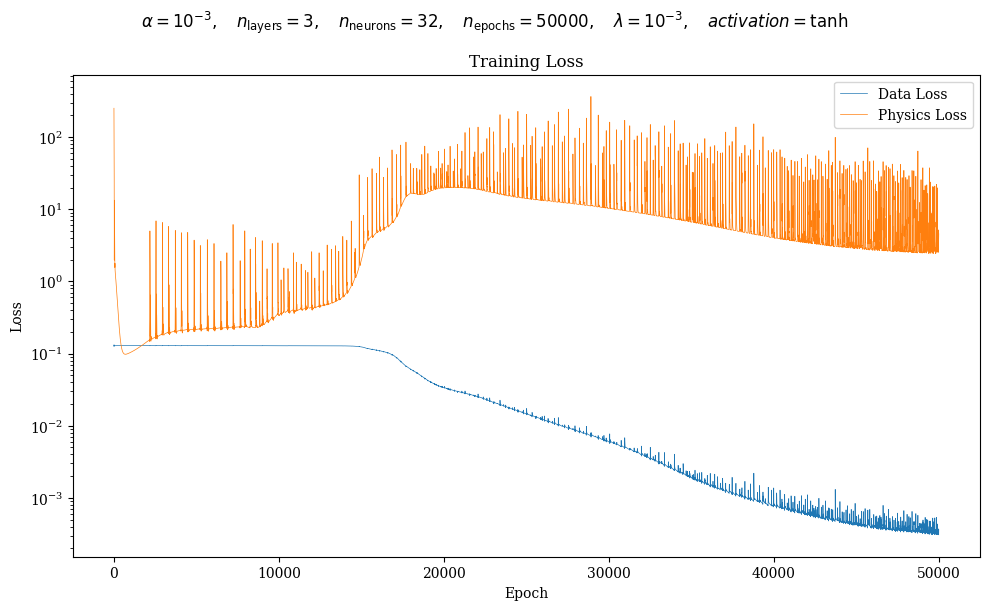

In [109]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="dataloss",  ax=ax1, label="Data Loss", linewidth=0.5)
pd.DataFrame(plot_loss_train).plot(x="epoch", y="physicsloss", ax=ax1, label="Physics Loss", linewidth=0.5)

ax1.set_xlabel(r"Epoch")
ax1.set_ylabel(r"Loss")
ax1.set_title(r"Training Loss")
ax1.set_yscale('log')
ax1.legend()

plt.suptitle(r"$\alpha=10^{-3},\quad n_{\text{layers}}=3,\quad n_{\text{neurons}}=32, \quad n_{\text{epochs}}=50000, \quad \lambda=10^{-3}, \quad activation=\tanh$")
plt.tight_layout()
plt.savefig(f"{folder_path}/training_loss.png", dpi=300)

pd.DataFrame(x_train.cpu().numpy(), columns=["time"]).to_parquet(f"{folder_path}/x_train.parquet")
pd.DataFrame(y_train.cpu().numpy(), columns=["displacement"]).to_parquet(f"{folder_path}/y_train.parquet")

torch.save(model, f"{folder_path}/pinn_model.pth")
torch.save(model.state_dict(), f"{folder_path}/pinn_weights.pth")

## results

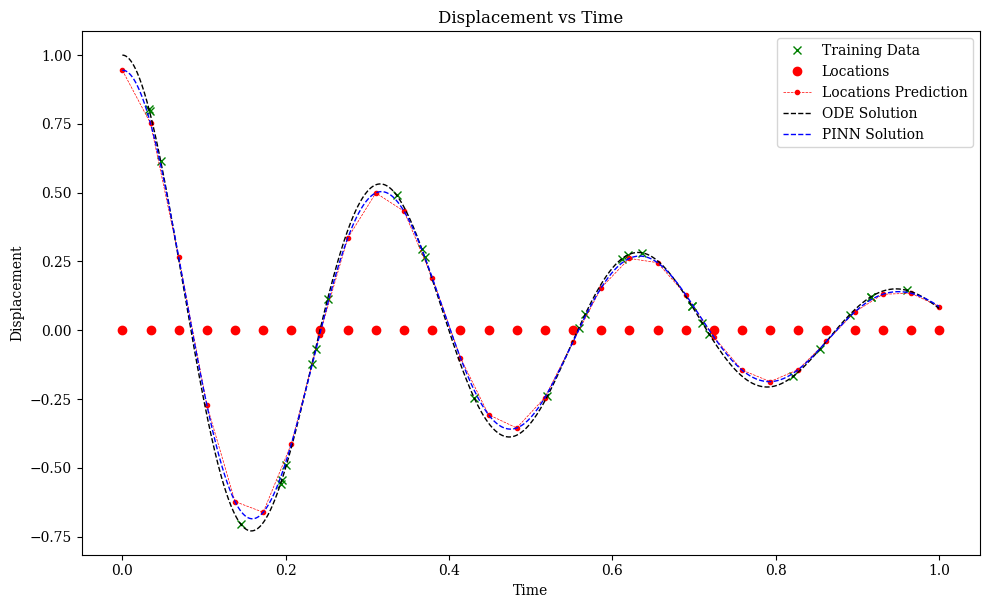

In [110]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))

model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

X.query(f"time <= {train_test_threshold}").plot(
    x="time", y="displacement", 
    marker="x", c="g", linestyle="none", linewidth=0.5,
    ax=ax1, label="Training Data"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o", linewidth=0.5,
    label=r"Locations", 
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".", linewidth=0.5,
    label=r"Locations Prediction"
) 

t = np.linspace(0, 1, 1000)

ax1.plot(t, oscillator(d, w0, torch.tensor(t)).detach().numpy(), label="ODE Solution", c="k", linestyle="--", linewidth=1,)

ax1.plot(t, model(torch.tensor(t).float().unsqueeze(1).to(device)).cpu().detach().numpy(), label="PINN Solution", c="b", linestyle="--", linewidth=1,)

ax1.set_xlabel("Time")
ax1.set_ylabel("Displacement")
ax1.legend()

plt.title("Displacement vs Time")
plt.tight_layout()

plt.savefig(f"{folder_path}/displacement_vs_time_with_predictions.png", dpi=300)

# extrapolation

## trained model

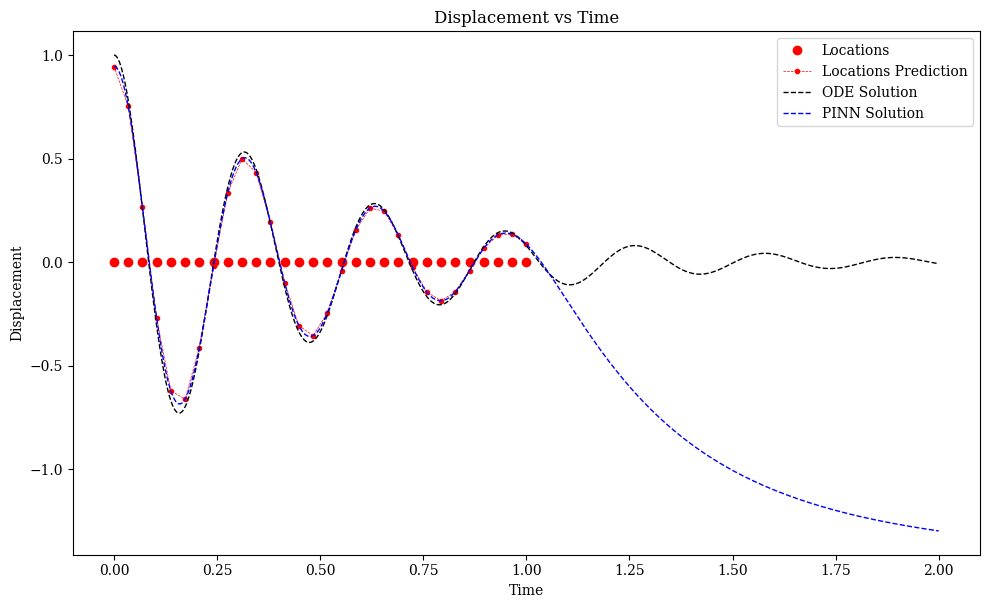

In [77]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o", linewidth=0.5,
    label=r"Locations", 
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".", linewidth=0.5,
    label=r"Locations Prediction"
) 

t = np.linspace(0, 2, 1000)

ax1.plot(t, oscillator(d, w0, torch.tensor(t)).detach().numpy(), label="ODE Solution", c="k", linestyle="--", linewidth=1,)

ax1.plot(t, model(torch.tensor(t).float().unsqueeze(1).to(device)).cpu().detach().numpy(), label="PINN Solution", c="b", linestyle="--", linewidth=1,)

ax1.set_xlabel("Time")
ax1.set_ylabel("Displacement")
ax1.legend()

plt.title("Displacement vs Time")
plt.tight_layout()

plt.savefig(f"{folder_path}/displacement_vs_time_with_generalization.png", dpi=300)

## train, out-of-sample setup

In [8]:
folder_path = f"../data/08_reporting/{experiment_name}/extrapolation"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

,time,displacement
0,0.618593,0.270338
1,0.558739,0.286385
2,0.193708,0.783977
3,0.335972,-0.168341
4,0.200845,0.775981


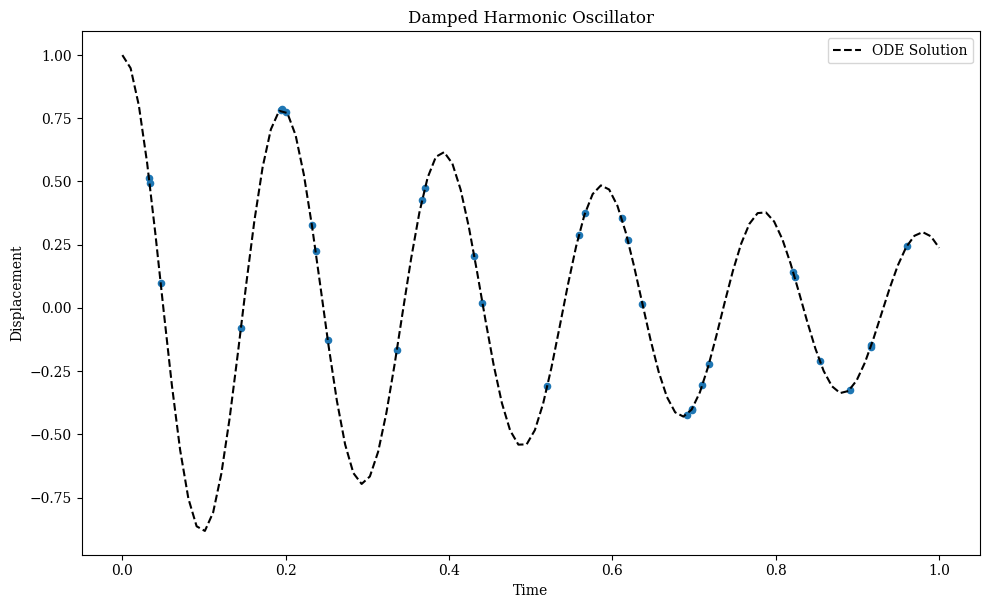

In [9]:
torch.manual_seed(33) 

d, w0 = 1.23, 32.1
x = torch.rand(33)
y = oscillator(d, w0, x).view(-1,1)

X = pd.DataFrame({"time": x.view(-1), "displacement": y.view(-1)})

display(X.head())
X.to_parquet(f"{folder_path}/synthetic_data.parquet")

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))

X.plot.scatter(x="time", y="displacement", ax=ax1,)

t = np.linspace(0, 1, 100)
ax1.plot(t, oscillator(d, w0, torch.tensor(t)).detach().numpy(), label="ODE Solution", c="k", linestyle="--",)

ax1.set_xlabel("Time")
ax1.set_ylabel("Displacement")
ax1.set_title("Damped Harmonic Oscillator")
ax1.legend()

plt.tight_layout()
plt.savefig(f"{folder_path}/displacement_vs_time.png", dpi=300)

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


  2%|▏         | 1072/50000 [00:01<01:37, 500.07it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.053256, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.053256


  4%|▍         | 2060/50000 [00:04<02:13, 358.63it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.003835, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.003835


  6%|▌         | 3103/50000 [00:05<01:15, 621.52it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.000056, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.000056


  8%|▊         | 4078/50000 [00:07<01:11, 642.89it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.000032, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.000032


 10%|▉         | 4973/50000 [00:08<01:13, 609.27it/s]/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 5034/50000 [00:09<01:23, 538.05it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.000030, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.000030


 12%|█▏        | 6061/50000 [00:12<02:04, 354.16it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.112521, Physics Loss: 547.739746, x0 Loss: 0.842250, v0 Loss: 25.283472, Total Loss: 0.169907


 14%|█▍        | 7058/50000 [00:15<02:08, 334.23it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.108441, Physics Loss: 226.894501, x0 Loss: 0.889821, v0 Loss: 1.337678, Total Loss: 0.131353


 16%|█▌        | 8058/50000 [00:18<02:07, 329.68it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.106434, Physics Loss: 184.549561, x0 Loss: 0.873571, v0 Loss: 0.034721, Total Loss: 0.124980


 18%|█▊        | 9050/50000 [00:21<01:57, 349.04it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.096748, Physics Loss: 148.125595, x0 Loss: 0.791263, v0 Loss: 0.359275, Total Loss: 0.111676


 20%|██        | 10055/50000 [00:24<01:51, 358.23it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.069993, Physics Loss: 95.889015, x0 Loss: 0.512485, v0 Loss: 3.439511, Total Loss: 0.079977


 22%|██▏       | 11066/50000 [00:27<02:04, 312.43it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.047390, Physics Loss: 137.937943, x0 Loss: 0.300139, v0 Loss: 3.048301, Total Loss: 0.061519


 24%|██▍       | 12036/50000 [00:31<03:13, 195.87it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.034319, Physics Loss: 148.444382, x0 Loss: 0.202043, v0 Loss: 2.462387, Total Loss: 0.049430


 26%|██▌       | 13021/50000 [00:36<03:06, 198.44it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.024776, Physics Loss: 151.278488, x0 Loss: 0.136057, v0 Loss: 1.708464, Total Loss: 0.040088


 28%|██▊       | 14035/50000 [00:41<03:05, 194.29it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.017752, Physics Loss: 167.272827, x0 Loss: 0.089292, v0 Loss: 1.065866, Total Loss: 0.034595


 30%|███       | 15019/50000 [00:46<03:03, 190.58it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.012590, Physics Loss: 136.198608, x0 Loss: 0.060643, v0 Loss: 0.721709, Total Loss: 0.026288


 32%|███▏      | 16037/50000 [00:52<02:59, 189.10it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.008425, Physics Loss: 92.777840, x0 Loss: 0.039733, v0 Loss: 0.399411, Total Loss: 0.017747


 34%|███▍      | 17059/50000 [00:55<01:30, 365.89it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.004685, Physics Loss: 42.207741, x0 Loss: 0.022609, v0 Loss: 0.084093, Total Loss: 0.008916


 36%|███▌      | 18056/50000 [00:58<01:32, 344.38it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.001683, Physics Loss: 7.190082, x0 Loss: 0.008698, v0 Loss: 0.004474, Total Loss: 0.002403


 38%|███▊      | 19021/50000 [01:02<02:40, 193.04it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.000484, Physics Loss: 0.599850, x0 Loss: 0.002279, v0 Loss: 0.027875, Total Loss: 0.000547


 40%|████      | 20028/50000 [01:07<02:30, 198.97it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.000168, Physics Loss: 0.141315, x0 Loss: 0.000552, v0 Loss: 0.128083, Total Loss: 0.000195


 42%|████▏     | 21032/50000 [01:12<02:22, 202.68it/s]

mass =  1.0 damping =  2.4600000381469727 spring =  1030.4100341796875
Data Loss: 0.000098, Physics Loss: 2.034657, x0 Loss: 0.000285, v0 Loss: 0.202143, Total Loss: 0.000322


100%|██████████| 50000/50000 [01:15<00:00, 666.23it/s]  


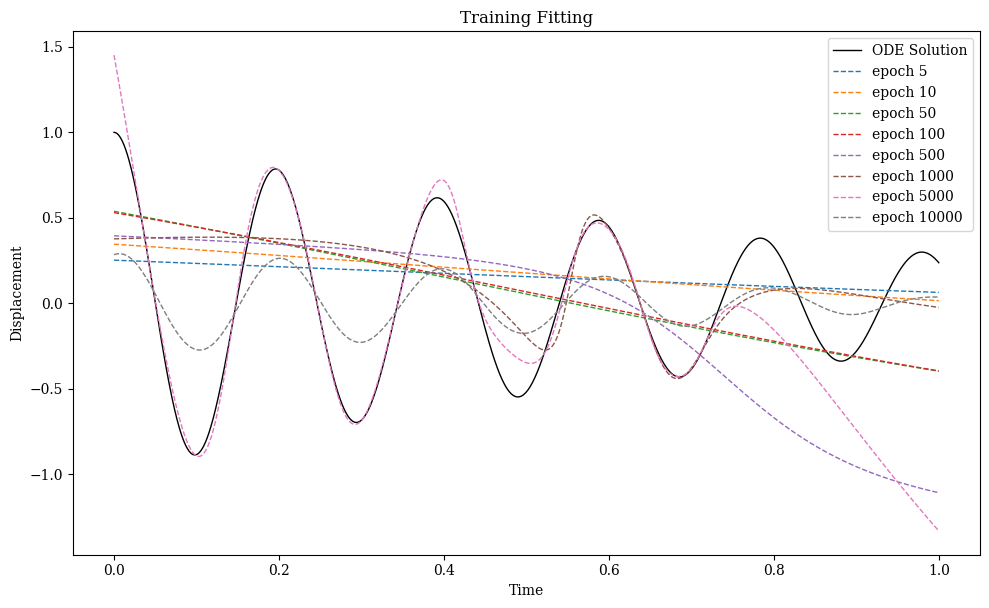

In [53]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            # _architecture.append(nn.BatchNorm1d(layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

m = 1
# k = 1
# mu = 0.1
mu, k = 2*d, w0**2
x_0 = 1
v_0 = 0

torch.manual_seed(123)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_test_threshold = 0.8

x_train = torch.tensor(X.query(f"time <= {train_test_threshold}")["time"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X.query(f"time <= {train_test_threshold}")["displacement"].values).float().unsqueeze(1).to(device)

x_test = torch.tensor(X.query(f"time > {train_test_threshold}")["time"].values).float().unsqueeze(1).to(device)
y_test = torch.tensor(X.query(f"time > {train_test_threshold}")["displacement"].values).float().unsqueeze(1).to(device)

hparam_dict = {
    'learning_rate': 1e-3,
    'n_layers': 3,
    'n_neurons': 32,
    'num_epochs': 50000,
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

model = MultiLayerPerceptronRegressor(architecture, nn.Tanh)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[])

_locations = torch.linspace(0, 1, 30).view(-1,1).requires_grad_(True).to(device)
_m = torch.tensor(m, dtype=torch.float, requires_grad=False).to(device)
_mu = torch.tensor(mu, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(k, dtype=torch.float, requires_grad=False).to(device)
_x0 = torch.tensor(x_0, dtype=torch.float, requires_grad=False).to(device)
_v0 = torch.tensor(v_0, dtype=torch.float, requires_grad=False).to(device)

loss = torch.tensor(1e6, dtype=torch.float, requires_grad=False).to(device)

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))
ax1.plot(t, oscillator(d, w0, torch.tensor(t)).detach().numpy(), label="ODE Solution", c="k", linestyle="-", linewidth=1,)

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    if loss.item() > 1e-4 or epoch < 10000:
        optimizer.zero_grad()

        # forward
        y_train_hat = model(x_train)
        data_loss = criterion(y_train_hat, y_train)

        y_location_hat = model(_locations)
        dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]
        dy2dt2 = torch.autograd.grad(dydt, _locations, grad_outputs=torch.ones_like(dydt), create_graph=True)[0]

        _diff_equation = _m*dy2dt2 + _mu*dydt + _k*y_location_hat
        
        if epoch > 5000:
            physics_loss = criterion(_diff_equation, torch.zeros_like(_diff_equation))
            _x0_loss = criterion(y_location_hat[0], _x0)
            _v0_loss = criterion(dydt[0], _v0)
        else:
            physics_loss = torch.tensor(0, dtype=torch.float, requires_grad=False).to(device)
            _x0_loss = torch.tensor(0, dtype=torch.float, requires_grad=False).to(device)
            _v0_loss = torch.tensor(0, dtype=torch.float, requires_grad=False).to(device)

        loss = data_loss + (1e-4)*(physics_loss + _x0_loss + _v0_loss)
        
        # backward
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 1000 == 0:
            str_epoch = str(epoch+1).zfill(5)
            str_num_epochs = str(num_epochs).zfill(5)
            str_loss = str(round(loss.item(), 4))
            str_physics_loss = str(round(physics_loss.item(), 4))
            # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
            print("mass = ", _m.item(), "damping = ", _mu.item(), "spring = ", _k.item())
            print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, x0 Loss: {_x0_loss.item():.6f}, v0 Loss: {_v0_loss.item():.6f}, Total Loss: {loss.item():.6f}")

        if (epoch+1) % 5 == 0:
            plot_loss_train["epoch"].append(epoch+1)
            plot_loss_train["dataloss"].append(data_loss.item())
            plot_loss_train["physicsloss"].append(physics_loss.item())
        
        if (epoch+1) in [5e0, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4]:
            model.eval()
            t = np.linspace(0, 1, 1000)
            ax1.plot(t, model(torch.tensor(t).float().unsqueeze(1).to(device)).cpu().detach().numpy(), label=f"epoch {epoch+1}", linestyle="--", linewidth=1)
    

ax1.set_xlabel("Time")
ax1.set_ylabel("Displacement")
ax1.legend()

plt.title("Training Fitting")
plt.tight_layout()

plt.savefig(f"{folder_path}/displacement_vs_time_with_training.png", dpi=300)

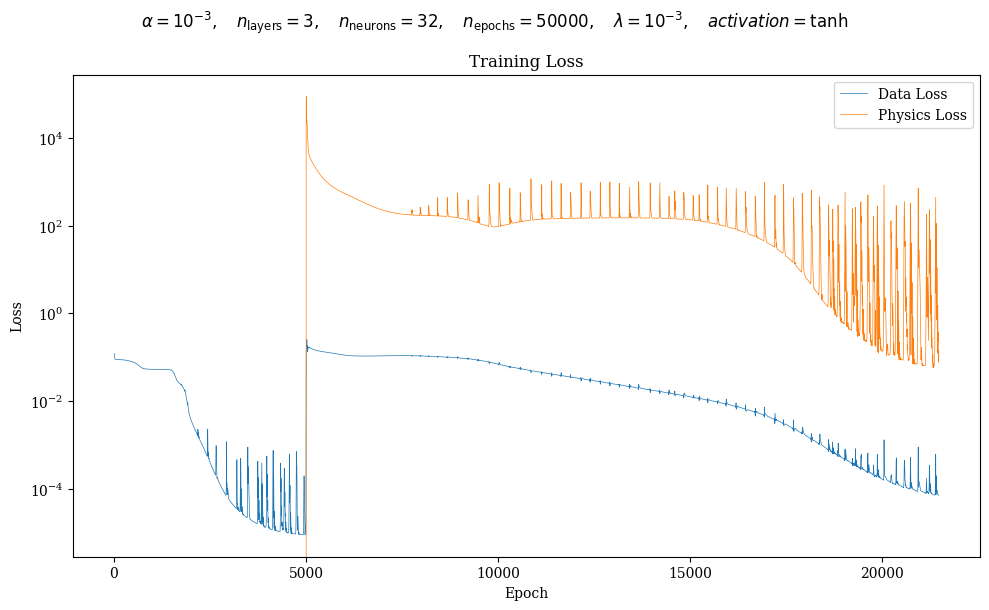

In [54]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="dataloss",  ax=ax1, label="Data Loss", linewidth=0.5)
pd.DataFrame(plot_loss_train).plot(x="epoch", y="physicsloss", ax=ax1, label="Physics Loss", linewidth=0.5)

ax1.set_xlabel(r"Epoch")
ax1.set_ylabel(r"Loss")
ax1.set_title(r"Training Loss")
ax1.set_yscale('log')
ax1.legend()

plt.suptitle(r"$\alpha=10^{-3},\quad n_{\text{layers}}=3,\quad n_{\text{neurons}}=32, \quad n_{\text{epochs}}=50000, \quad \lambda=10^{-3}, \quad activation=\tanh$")
plt.tight_layout()
plt.savefig(f"{folder_path}/training_loss.png", dpi=300)

pd.DataFrame(x_train.cpu().numpy(), columns=["time"]).to_parquet(f"{folder_path}/x_train.parquet")
pd.DataFrame(y_train.cpu().numpy(), columns=["displacement"]).to_parquet(f"{folder_path}/y_train.parquet")

torch.save(model, f"{folder_path}/pinn_model.pth")
torch.save(model.state_dict(), f"{folder_path}/pinn_weights.pth")

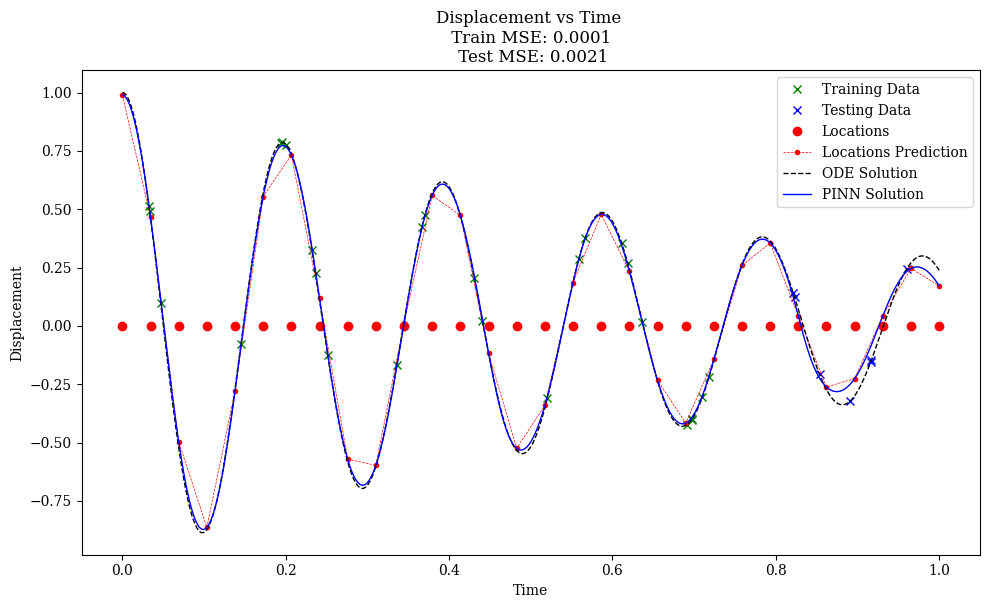

In [60]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))

model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

X.query(f"time <= {train_test_threshold}").plot(
    x="time", y="displacement", 
    marker="x", c="g", linestyle="none", linewidth=0.5,
    ax=ax1, label="Training Data"
)

X.query(f"time > {train_test_threshold}").plot(
    x="time", y="displacement", 
    marker="x", c="b", linestyle="none", linewidth=0.5,
    ax=ax1, label="Testing Data"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o", linewidth=0.5,
    label=r"Locations", 
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".", linewidth=0.5,
    label=r"Locations Prediction"
) 

t = np.linspace(0, 1, 1000)

ax1.plot(t, oscillator(d, w0, torch.tensor(t)).detach().numpy(), label="ODE Solution", c="k", linestyle="--", linewidth=1,)

ax1.plot(t, model(torch.tensor(t).float().unsqueeze(1).to(device)).cpu().detach().numpy(), label="PINN Solution", c="b", linestyle="-", linewidth=1,)

train_mse = mean_squared_error(X.query(f"time <= {train_test_threshold}")["displacement"], X.query(f"time <= {train_test_threshold}")["y_hat"])
test_mse = mean_squared_error(X.query(f"time > {train_test_threshold}")["displacement"], X.query(f"time > {train_test_threshold}")["y_hat"])

ax1.set_xlabel("Time")
ax1.set_ylabel("Displacement")
ax1.legend()

plt.title("Displacement vs Time \n Train MSE: {:.4f} \n Test MSE: {:.4f}".format(train_mse, test_mse))
plt.tight_layout()

plt.savefig(f"{folder_path}/displacement_vs_time_with_predictions.png", dpi=300)

### polynomial

In [64]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

preg = make_pipeline(PolynomialFeatures(5), LinearRegression())
preg.fit(
    X.query(f"time <= {train_test_threshold}")["time"].values.reshape(-1,1), 
    X.query(f"time <= {train_test_threshold}")["displacement"].values.reshape(-1,1)
)

X["preg"] = preg.predict(X["time"].values.reshape(-1,1))

preg_train_mse = mean_squared_error(X.query(f"time <= {train_test_threshold}")["displacement"], X.query(f"time <= {train_test_threshold}")["preg"])
preg_test_mse = mean_squared_error(X.query(f"time > {train_test_threshold}")["displacement"], X.query(f"time > {train_test_threshold}")["preg"])

print(preg_train_mse)
print(preg_test_mse)

0.0713536
94.72146


In [84]:
# from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler()

# X_scaled = pd.concat([
#     X.query(f"time <= {train_test_threshold}")[["time"]],
#     pd.DataFrame(scaler.fit_transform(X.query(f"time <= {train_test_threshold}")[["time", "displacement"]]))
# ], axis=1)

# svr = SVR(C=1.0, epsilon=0.2, kernel='rbf')

# svr.fit(
#     X_scaled[[0]],
#     X_scaled[[1]]
# )


.